<a href="https://colab.research.google.com/github/muzakkialfarisi/MACHINE-LEARNING/blob/master/word2vec_skipgram_short.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tutorial Pekan keempat**

Membangun model **word2vec Skip-Gram** sederhana dengan Python dan Numpy

Menggunakan dataset kalimat lebih pendek dan epoch sedikit, untuk tracing

Sumber: https://github.com/nathanrooy/word2vec-from-scratch-with-python/blob/master/word2vec.py

Import library yang diperlukan

In [ ]:
import numpy as np
import re
from collections import defaultdict

Variabel-variabel yang akan digunakan

In [ ]:
word_counts_dict = defaultdict(int) # dictionary untuk menyimpan jumlah kemunculan kata dalam korpus
vocab_count = 0 # total jumlah kata yang ada pada corpus (|v|)
# lookup dictionaries
words = [] # list untuk menampung kata-kata yang muncul pada corpus (vocab) 
word_index_dict = {} # dictionary untuk menyimpan kata dan indeks yang sesuai 
index_word_dict = {} # dictionary untuk menyimpang indeks kata serta kata yang sesuai


Fungsi untuk menghitung jumlah kemunculan kata (word count)

In [ ]:
def compute_word_count(corpus):
    word_counts = defaultdict(int)
    for row in corpus:
        for word in row:
            word_counts[word] += 1

    v_count = len(word_counts.keys())
    return word_counts, v_count



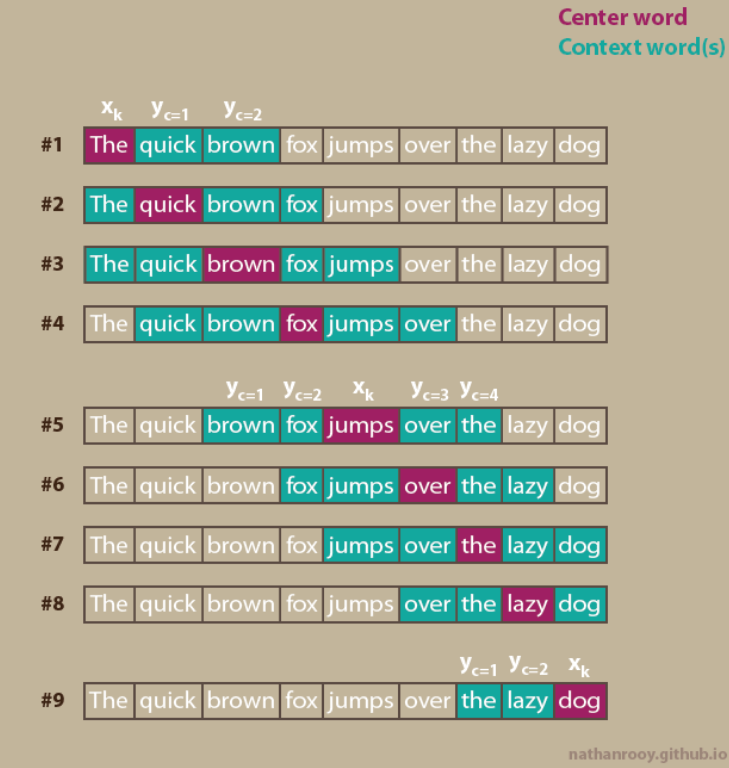

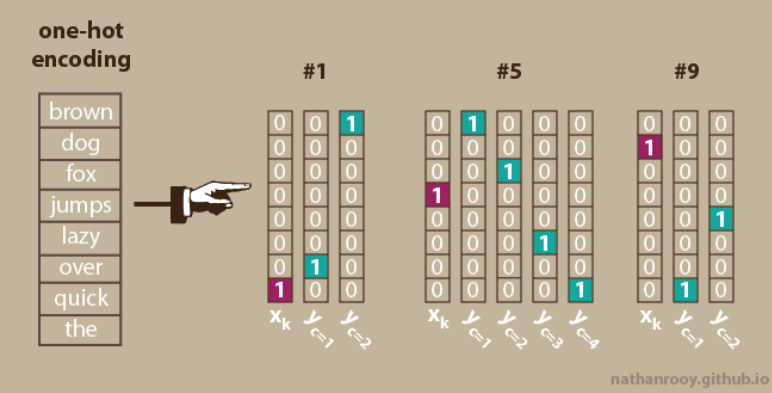

Fungsi untuk merepresentasikan kata dalam one-hot-encoding

In [ ]:
def word2onehot(v_count, w_index, word):   
    word_vec = [0 for i in range(0, v_count)]
    temp_word_index = w_index[word]
    word_vec[temp_word_index] = 1
    return word_vec

Fungsi untuk generate training data

In [ ]:
def generate_training_data(window_size, corpus):
    word_counts, v_count = compute_word_count(corpus) # hitung jumlah kemunculan kata pada korpus
    # masukkan informasi korpus pada lookup dictionaries
    words_list = sorted(list(word_counts.keys()),reverse=False) # kata diurutkan berdasarkan alfabet
    word_index = dict((word, i) for i, word in enumerate(words_list))
    index_word = dict((i, word) for i, word in enumerate(words_list))

    training_data = []
    # proses tiap kalimat dalam corpus
    for sentence in corpus:
        sent_len = len(sentence)

        # proses tiap kata dalam kalimat
        for i, word in enumerate(sentence):
            w_target = word2onehot(v_count, word_index, sentence[i]) # kata target, ubah representasi dalam one-hot-encoding
            # proses konteks sesuai dengan ukuran window
            w_context = []
            for j in range(i-window_size, i+window_size+1):
                if j!=i and j<=sent_len-1 and j>=0:
                    w_context.append(word2onehot(v_count, word_index, sentence[j])) # kata-kata context, ubah representasi dalam one-hot-encoding
            training_data.append([w_target, w_context]) # masukkan kata target dan kata-kata context dalam training_data
   
    return word_counts, v_count, words_list, word_index, index_word, np.array(training_data)


In [ ]:
corpus = [['faris','suka','bermain','bola'],['faris','sedang','bermain','bola']] # contoh terdiri atas 1 kalimat

print(corpus)

[['faris', 'suka', 'bermain', 'bola'], ['faris', 'sedang', 'bermain', 'bola']]


Setting untuk persiapan vektor input

In [ ]:
settings = {}
settings['window_size'] = 2         # context window +/- center word

Tes generate training data

In [ ]:
word_counts_dict, vocab_count, words, word_index_dict, index_word_dict, training_data = generate_training_data(settings['window_size'], corpus)

In [ ]:
print(word_index_dict)

{'bermain': 0, 'bola': 1, 'faris': 2, 'sedang': 3, 'suka': 4}


In [ ]:
print(training_data[0])

[list([0, 0, 1, 0, 0]) list([[0, 0, 0, 0, 1], [1, 0, 0, 0, 0]])]


In [ ]:
print(training_data[2])

[list([1, 0, 0, 0, 0])
 list([[0, 0, 1, 0, 0], [0, 0, 0, 0, 1], [0, 1, 0, 0, 0]])]


In [ ]:
print(vocab_count)

5


In [ ]:
print(word_counts_dict)

defaultdict(<class 'int'>, {'faris': 2, 'suka': 1, 'bermain': 2, 'bola': 2, 'sedang': 1})


# Fungsi-fungsi Neural Network

fungsi aktivasi softmax

In [ ]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

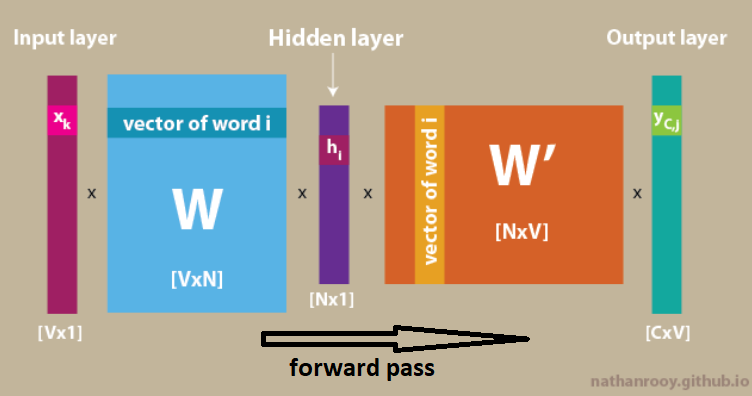

forward pass

h=xT.W

uc = W′T.h

yc = softmax(u)


In [ ]:
def forward_pass(w1, w2, x):   
    h = np.dot(w1.T, x)
    u = np.dot(w2.T, h)
    y_c = softmax(u)
    return y_c, h, u

backpropagation

In [ ]:
def backprop(w1_input, w2_input, eta, e, h, x):
    dl_dw2 = np.outer(h, e)  
    dl_dw1 = np.outer(x, np.dot(w2_input, e.T))

    # UPDATE WEIGHTS
    w1_updated = w1_input - (eta * dl_dw1)
    w2_updated = w2_input - (eta * dl_dw2)
    return w1_updated,w2_updated

# Pelatihan word2vec

Setting untuk persiapan training

In [ ]:
settings['n'] = 2                   # dimension of word embeddings
settings['epochs'] = 2              # number of training epochs
settings['learning_rate'] = 0.01    # learning rate
np.random.seed(0)                   # set the seed for reproducibility

In [ ]:
def train(v_count, n, training_data, epochs, eta):
    #print('v_count=',v_count)
    #print('n=',n)
    # INITIALIZE WEIGHT MATRICES
    w1 = np.random.uniform(-0.8, 0.8, (v_count, n))     # embedding matrix
    w2 = np.random.uniform(-0.8, 0.8, (n, v_count))     # context matrix
    print('initial w1:')
    print(w1)
    print('initial w2:')
    print(w2)     
    # CYCLE THROUGH EACH EPOCH
    for i in range(0, epochs):
        print('******************EPOCH ke-',i,'************************')
        loss = 0

        # CYCLE THROUGH EACH TRAINING SAMPLE
        for w_t, w_c in training_data:
            print('================Start training on each example===============')
            print('w target:')
            print(w_t)
            print('w context:')
            print(w_c)
            print('w1:')
            print(w1)
            print('w2:')
            print(w2)
            # FORWARD PASS
            y_pred, h, u = forward_pass(w1, w2, w_t)
            
            print('prediksi output=',y_pred)    

            # CALCULATE ERROR
            EI = np.sum([np.subtract(y_pred, word) for word in w_c], axis=0)
            
            for word in w_c:
                print('word context:',word)
                #np.subtract(y_pred, word) for word in w_c
                print('Error:',np.subtract(y_pred, word))

            print('Error total for all context = ',EI)

            # BACKPROPAGATION
            w1, w2 = backprop(w1, w2, eta, EI, h, w_t)
            print('w1 update setelah backpropagration:')
            print(w1)
            print('w2 update setelah backpropagration:')
            print(w2)

            # CALCULATE LOSS
            # penjelasan lebih lengkap tentang fungsi loss ini dapat dibaca di artikel "word2vec Parameter Learning Explained", https://arxiv.org/pdf/1411.2738.pdf
            print('embedding output(u):')
            print(u)
            for word in w_c:
                print('elemen embedding u untuk kata ',word,':',u[word.index(1)])
            loss += -np.sum([u[word.index(1)] for word in w_c]) + len(w_c) * np.log(np.sum(np.exp(u))) 
            print('loss per instance training data=',loss)  
            print('================End training on each example===============')  
        print('EPOCH:',i, 'LOSS:', loss)
        #pass
    return w1,w2

# Fungsi untuk akses vektor/embedding kata dan mendapatkan beberapa kata dengan similarity tertinggi

fungsi untuk mendapatkan vektor sebuah kata

In [ ]:
def word_vec(w1, word, word_index):
    w_index = word_index[word]
    v_w = w1[w_index]
    #print('word vector untuk kata ',word,'=',v_w)
    return v_w

fungsi untuk mendapatkan top-n kata paling similar/mirip

In [ ]:
def word_sim(w1, word, top_n):
        
    w1_index = word_index_dict[word]
    v_w1 = w1[w1_index]

    # CYCLE THROUGH VOCAB
    word_sim = {}
    for i in range(vocab_count):
        v_w2 = w1[i]
        theta_num = np.dot(v_w1, v_w2)
        theta_den = np.linalg.norm(v_w1) * np.linalg.norm(v_w2)
        theta = theta_num / theta_den

        word = index_word_dict[i]
        word_sim[word] = theta

    #words_sorted = sorted(word_sim.items(), key=lambda(word, sim):sim, reverse=True)
    words_sorted = {k: v for k, v in sorted(word_sim.items(), key=lambda item: item[1], reverse=True)}

    
    words_sorted_list = list(words_sorted.items())
    
    for word in words_sorted_list[:2]:
        print(word)        
            
    pass

# Tes training word2vec

pelatihan word2vec

In [ ]:
w1, w2 = train(vocab_count, settings['n'], training_data, settings['epochs'], settings['learning_rate'])

initial w1:
[[ 0.07810161  0.34430299]
 [ 0.1644214   0.07181309]
 [-0.12215232  0.23343058]
 [-0.09986046  0.6268368 ]
 [ 0.74186042 -0.18649357]]
initial w2:
[[ 0.46676006  0.04623187  0.1088713   0.68095462 -0.68634231]
 [-0.66059312 -0.76765056  0.53219175  0.4450508   0.59201944]]
******************EPOCH ke- 0 ************************
================Start training on each example===============
w target:
[0, 0, 1, 0, 0]
w context:
[[0, 0, 0, 0, 1], [1, 0, 0, 0, 0]]
w1:
[[ 0.07810161  0.34430299]
 [ 0.1644214   0.07181309]
 [-0.12215232  0.23343058]
 [-0.09986046  0.6268368 ]
 [ 0.74186042 -0.18649357]]
w2:
[[ 0.46676006  0.04623187  0.1088713   0.68095462 -0.68634231]
 [-0.66059312 -0.76765056  0.53219175  0.4450508   0.59201944]]
prediksi output= [0.16102768 0.16533179 0.22223285 0.20306031 0.24834738]
word context: [0, 0, 0, 0, 1]
Error: [ 0.16102768  0.16533179  0.22223285  0.20306031 -0.75165262]
word context: [1, 0, 0, 0, 0]
Error: [-0.83897232  0.16533179  0.22223285  0.203

Coba print embedding kata hasil pelatihan

In [ ]:
print(word_vec(w1,'faris',word_index_dict))
print(word_vec(w1,'suka',word_index_dict))
print(word_vec(w1,'bermain',word_index_dict))
print(word_vec(w1,'bola',word_index_dict))
print(word_vec(w1,'sedang',word_index_dict))

[-0.10980476  0.21809797]
[ 0.73817893 -0.19961937]
[0.07087994 0.33859953]
[0.17049649 0.06290772]
[-0.09000846  0.59464366]


Mencoba mencari kata yang paling mirip (most-similar)

In [ ]:
word_sim(w1,'faris',2)

('faris', 1.0000000000000002)
('sedang', 0.9504267059431852)


In [ ]:
#aku lagi bersama teman
#aku futsal bersama teman

print(word2onehot(5,word_index_dict,'faris'))
print(word2onehot(5,word_index_dict,'suka'))
print(word2onehot(5,word_index_dict,'bermain'))
print(word2onehot(5,word_index_dict,'bola'))
print(word2onehot(5,word_index_dict,'sedang'))


[0, 0, 1, 0, 0]
[0, 0, 0, 0, 1]
[1, 0, 0, 0, 0]
[0, 1, 0, 0, 0]
[0, 0, 0, 1, 0]
